# Smart Classroom Data Evaluation

## Informationen zur Analyse

### Klassenzimmer "Primarklasse_OG1" / Schulklasse 4a

--- Markdown ---

Stundenplan: <br/><br/>
<img src='Studenplan 4a Oben.png' width=500px height=auto>

### Klassenzimmer "Primarklasse_EG" / Schulklasse 5a

--- Markdown ---

Stundenplan: <br/><br/>
<img src='Stundenplan 5a.png' width=500px height=auto>

### Klassenzimmer "oberstufe" / Verschiedene Klassen

Stundenplan: <br/> <br/>
<img src='Oberstufe.png' width=500px height=auto>


Schülerzahlen:
- B1: 20
- B2: 13
- B3: 21
- E1: 10
- E2: 16
- E3: 14

## Setup

### Imports

In [1]:
import psycopg2
import configparser
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Settings

In [2]:
plt.rcParams['timezone'] = "CET"
meteofile = "2022_05_22_meteoswiss.txt"

### Setup connection

In [3]:
def read_config(filename = 'config.ini'):
    config = configparser.ConfigParser()
    config.read(filename)

    db_hostname = config['DATABASE']['HOSTNAME']
    db_database = config['DATABASE']['DATABASE']
    db_username = config['DATABASE']['USERNAME']
    db_password = config['DATABASE']['PASSWORD']

    return db_hostname, db_database, db_username, db_password

In [4]:
def get_connection():
    db_hostname, db_database, db_username, db_password = read_config()
    return  psycopg2.connect(
        host     = db_hostname,
        database = db_database,
        user     = db_username,
        password = db_password)

### Define function for querying measurements

In [5]:
# get all Classrooms from database and filter them
def get_measurement(name, startDate, endDate):
    con = get_connection()

    sql_stations = f"""
        set timezone = 'CET'; 
        select * from api_classroom
        inner join api_measurementstation on api_classroom.id = api_measurementstation.fk_classroom_id
        inner join api_measurement on api_measurementstation.id = api_measurement.fk_measurement_station_id
        where api_classroom.name = '{name}' and time BETWEEN '{startDate}' AND '{endDate}';
    """    
    result = pd.read_sql_query(sql_stations, con)
    
    result["time"]        = result["time"].dt.tz_convert("CET")
    result["updated_on"]  = result["updated_on"].dt.tz_convert("CET")
    result["insert_time"] = result["insert_time"].dt.tz_convert("CET")
    
    con.close()
    return result

In [6]:
def get_entrance(name, startDate, endDate):
    con = get_connection()

    sql_stations = f"""
        set timezone = 'CET'; 
        select * from api_classroom
        inner join api_measurementstation on api_classroom.id = api_measurementstation.fk_classroom_id
        inner join api_entranceevent on api_measurementstation.id = api_entranceevent.fk_measurement_station_id
        where time BETWEEN '{startDate}' AND '{endDate}' and api_classroom.name = '{name}';
    """    
    result = pd.read_sql_query(sql_stations, con)
    
    result["time"]        = result["time"].dt.tz_convert("CET")
    result["updated_on"]  = result["updated_on"].dt.tz_convert("CET")
    result["insert_time"] = result["insert_time"].dt.tz_convert("CET")
    
    con.close()
    
    result = result.sort_values(['time'])

        
    return result

In [7]:
def get_meteo(startDate, endDate):
    meteo = pd.read_csv(meteofile, delimiter = ';')
    meteo.columns = ["Station",
                 "Time", 
                 "Lufttemperatur 2 m über Boden; Momentanwert in °C", 
                 "Niederschlag; gleitende Stundensumme (über 6 Zehnminutenintervalle) in mm", 
                 "Original Luftfeuchtigkeit 2 m über Boden; Momentanwert in %", 
                 "Relative Luftfeuchtigkeit 2 m über Boden; Momentanwert in %",
                 "Windgeschwindigkeit; Zehnminutenmittel in %"]

    meteo["Time"] = pd.to_datetime(meteo["Time"], format = "%Y%m%d%H%M")
    meteo["Time"] = meteo["Time"] + pd.Timedelta(hours = 2)
    meteo = meteo.set_index("Time")

    if startDate != None:
        meteo = meteo[meteo.index >= startDate]

    if endDate != None:
        meteo = meteo.loc[meteo.index <= endDate]

    return meteo
    

In [8]:
def get_people_count_overtime(entrance_list):
    people_count     = 0
    lst_people_count = []
    lst_time         = []
    array = []
    
    for index, row in entrance_list.iterrows():
        people_count += row['change']
        ttime = row['time']
        lst_people_count.append(people_count)
        lst_time.append(ttime) 
        
        d = dict({'people_count': people_count, 'time': ttime})
        array.append(d)
    df = pd.DataFrame.from_dict(array,orient='columns')
    df = df.sort_values(['time'], ascending=True)
    return df
    

## Evaluation / Forschungsfragen

### Wie ist der Zusammenhang zwischen Luftqualität und Frequenz bzw. Dauer des Lüftens?

##### Beispiel 1

In [9]:
data = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 09:30:00")

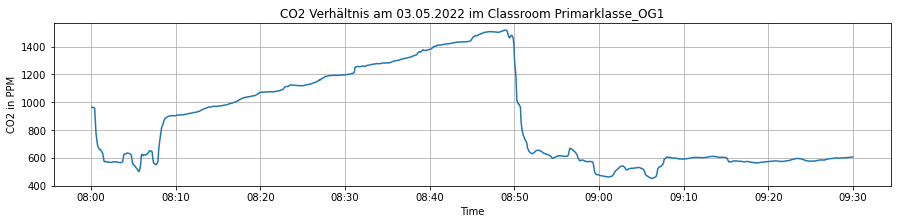

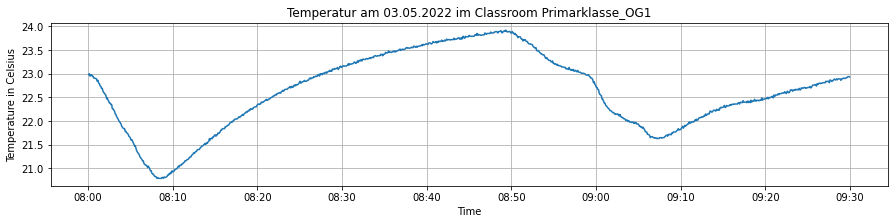

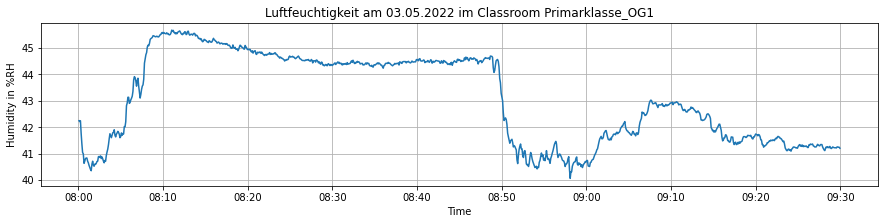

In [10]:
plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom Primarklasse_OG1")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.title("Temperatur am 03.05.2022 im Classroom Primarklasse_OG1")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["humidity"])
plt.xlabel("Time")
plt.ylabel("Humidity in %RH")
plt.title("Luftfeuchtigkeit am 03.05.2022 im Classroom Primarklasse_OG1")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

##### Beispiel 2

In [11]:
data = get_measurement("Primarklasse_EG", startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 09:30:00")

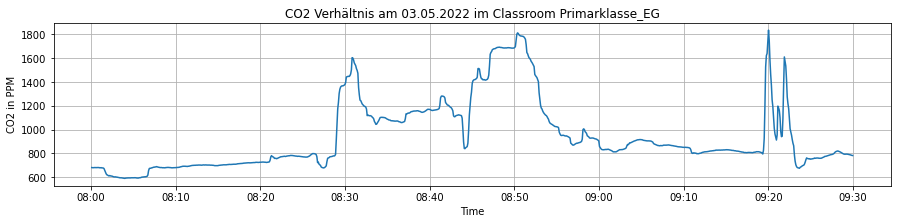

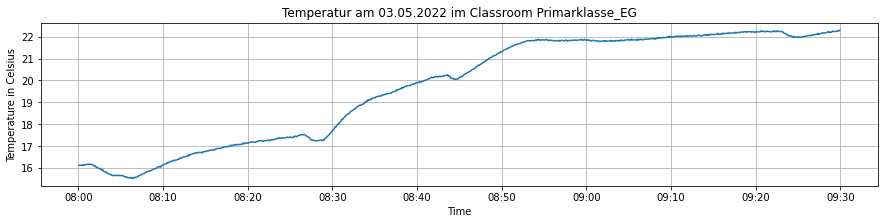

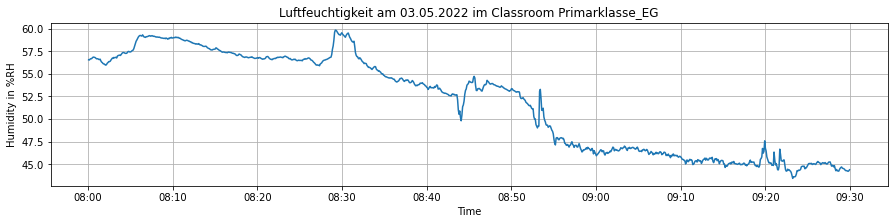

In [12]:
plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom Primarklasse_EG")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.title("Temperatur am 03.05.2022 im Classroom Primarklasse_EG")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["humidity"])
plt.xlabel("Time")
plt.ylabel("Humidity in %RH")
plt.title("Luftfeuchtigkeit am 03.05.2022 im Classroom Primarklasse_EG")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

##### Beispiel 3

In [13]:
data = get_measurement("oberstufe", startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 09:30:00")

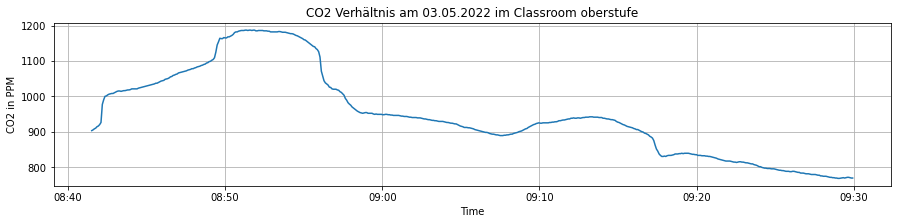

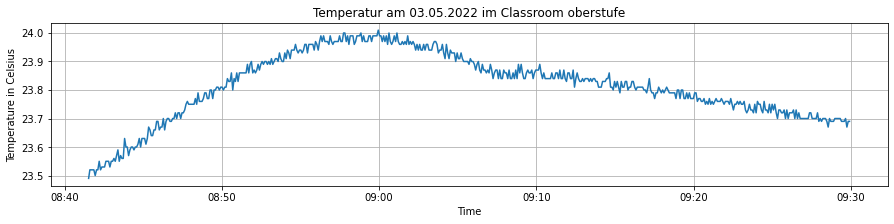

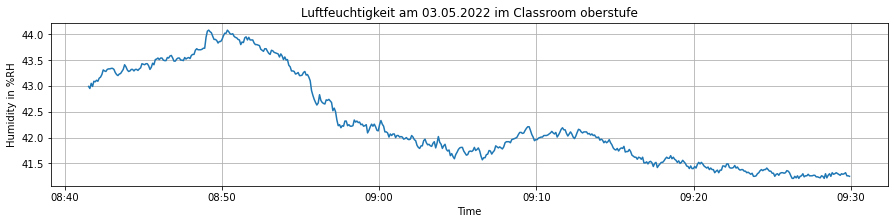

In [14]:
plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.title("Temperatur am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["humidity"])
plt.xlabel("Time")
plt.ylabel("Humidity in %RH")
plt.title("Luftfeuchtigkeit am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

### Lässt sich anhand der Luftqualität etwas über die Anzahl Personen im Raum aussagen?

#### With People counter

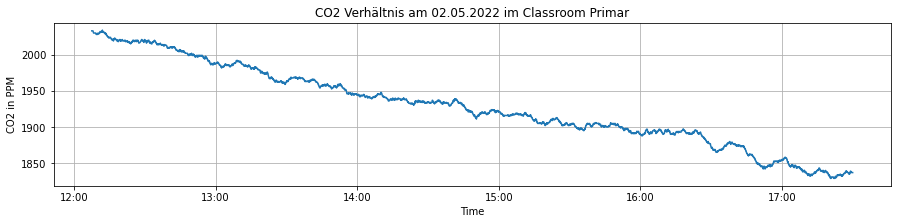

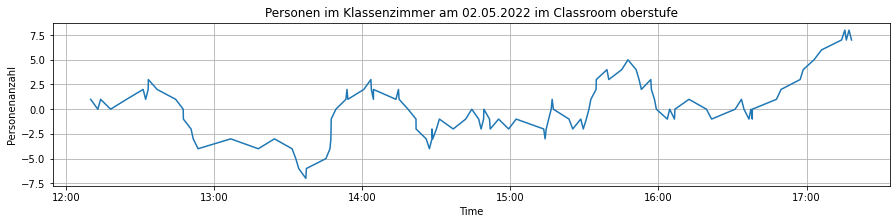

           id      id  fk_classroom_id             id          co2  \
count  3790.0  3790.0           3790.0    3790.000000  3789.000000   
mean      2.0     2.0              2.0  979106.054090  1928.174452   
std       0.0     0.0              0.0    3282.738828    54.063237   
min       2.0     2.0              2.0  973424.000000  1829.000000   
25%       2.0     2.0              2.0  976264.750000  1893.000000   
50%       2.0     2.0              2.0  979105.500000  1922.000000   
75%       2.0     2.0              2.0  981948.250000  1967.000000   
max       2.0     2.0              2.0  984791.000000  2034.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  3789.000000  3789.000000                     3790.0   3789.000000  
mean     24.415775    45.650491                        2.0  40329.045131  
std       0.604358     0.545692                        0.0     66.143147  
min      23.380000    44.660000                        2.0  40112.000

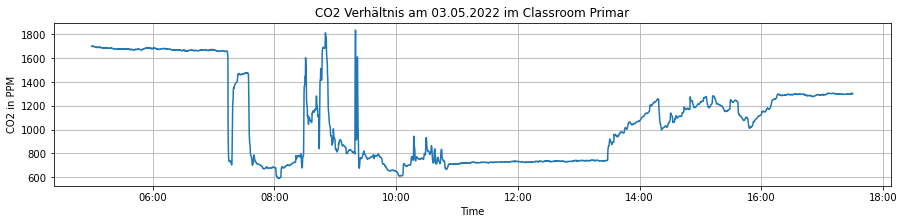

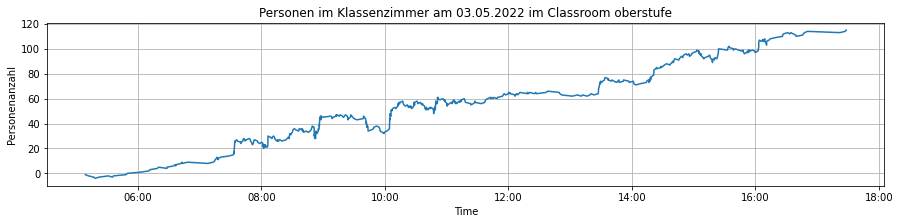

           id      id  fk_classroom_id            id          co2  \
count  8795.0  8795.0           8795.0  8.795000e+03  8788.000000   
mean      2.0     2.0              2.0  1.014279e+06  1086.413291   
std       0.0     0.0              0.0  7.110712e+03   360.547976   
min       2.0     2.0              2.0  1.003282e+06   591.000000   
25%       2.0     2.0              2.0  1.007682e+06   735.000000   
50%       2.0     2.0              2.0  1.013910e+06  1065.000000   
75%       2.0     2.0              2.0  1.020500e+06  1298.000000   
max       2.0     2.0              2.0  1.027095e+06  1836.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  8789.000000  8789.000000                     8795.0   8792.000000  
mean     23.443228    44.195764                        2.0  36013.732484  
std       2.498483     4.925492                        0.0  11658.953629  
min      15.520000    38.710000                        2.0    688.000000  
25%

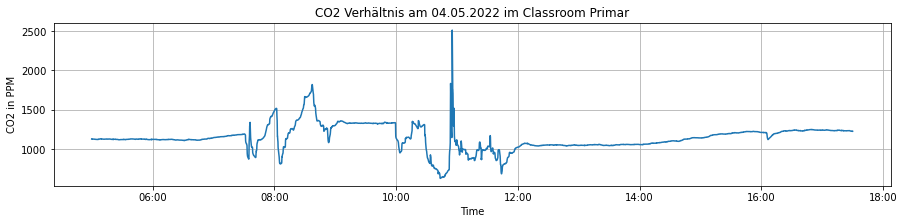

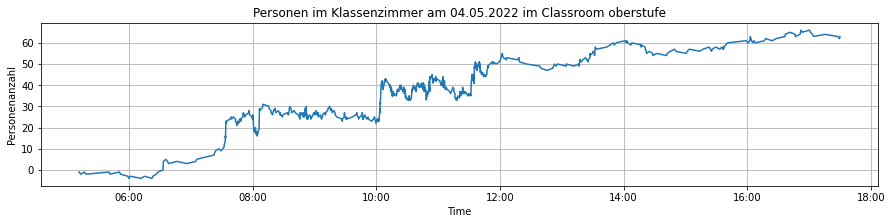

           id      id  fk_classroom_id            id          co2  \
count  8826.0  8826.0           8826.0  8.826000e+03  8818.000000   
mean      2.0     2.0              2.0  1.064711e+06  1143.597414   
std       0.0     0.0              0.0  7.649316e+03   156.977308   
min       2.0     2.0              2.0  1.051467e+06   628.000000   
25%       2.0     2.0              2.0  1.058088e+06  1057.000000   
50%       2.0     2.0              2.0  1.064712e+06  1127.000000   
75%       2.0     2.0              2.0  1.071335e+06  1233.000000   
max       2.0     2.0              2.0  1.077957e+06  2513.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  8820.000000  8819.000000                     8826.0   8817.000000  
mean     24.456984    44.253282                        2.0  35824.665986  
std       1.098643     1.470729                        0.0  12145.153038  
min      22.200000    41.260000                        2.0    880.000000  
25%

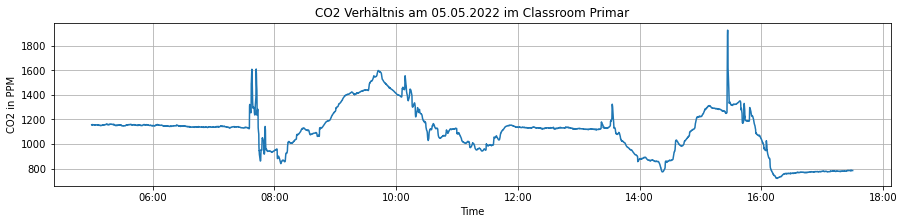

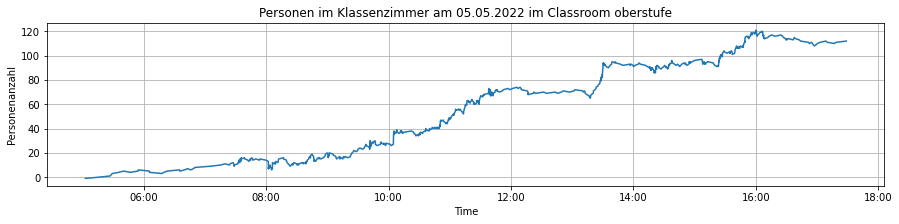

           id      id  fk_classroom_id            id          co2  \
count  8830.0  8830.0           8830.0  8.830000e+03  8825.000000   
mean      2.0     2.0              2.0  1.114245e+06  1102.520907   
std       0.0     0.0              0.0  7.649240e+03   186.942079   
min       2.0     2.0              2.0  1.101003e+06   720.000000   
25%       2.0     2.0              2.0  1.107621e+06   995.000000   
50%       2.0     2.0              2.0  1.114242e+06  1131.000000   
75%       2.0     2.0              2.0  1.120868e+06  1156.000000   
max       2.0     2.0              2.0  1.127496e+06  1925.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  8823.000000  8825.000000                     8830.0   8818.000000  
mean     23.731638    48.742916                        2.0  34449.876162  
std       0.716032     1.021649                        0.0  13281.770478  
min      22.090000    47.020000                        2.0    880.000000  
25%

In [15]:
## Week 1 Korrelation People to Co2

df_people = get_people_count_overtime(get_entrance('Primarklasse_EG', startDate = "2022-05-02 05:00:00", endDate = "2022-05-02 17:30:00"))
data = get_measurement(name = "Primarklasse_EG", startDate = "2022-05-02 05:00:00", endDate = "2022-05-02 17:30:00")



plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 02.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 02.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')


df_people = get_people_count_overtime(get_entrance('Primarklasse_EG', startDate = "2022-05-03 05:00:00", endDate = "2022-05-03 17:30:00"))
data = get_measurement(name = "Primarklasse_EG", startDate = "2022-05-03 05:00:00", endDate = "2022-05-03 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

df_people = get_people_count_overtime(get_entrance('Primarklasse_EG', startDate = "2022-05-04 05:00:00", endDate = "2022-05-04 17:30:00"))
data = get_measurement(name = "Primarklasse_EG", startDate = "2022-05-04 05:00:00", endDate = "2022-05-04 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 04.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 04.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

df_people = get_people_count_overtime(get_entrance('Primarklasse_EG', startDate = "2022-05-05 05:00:00", endDate = "2022-05-05 17:30:00"))
data = get_measurement(name = "Primarklasse_EG", startDate = "2022-05-05 05:00:00", endDate = "2022-05-05 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 05.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 05.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

#### Mit Studenplan Personen zählen und Klassenliste

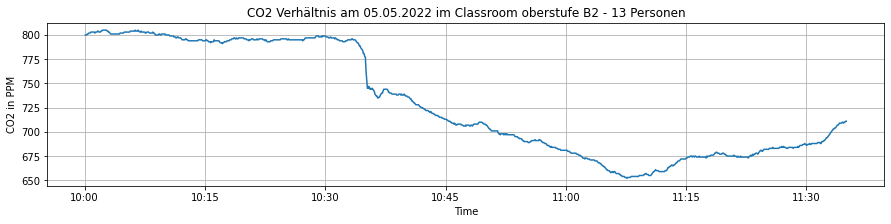

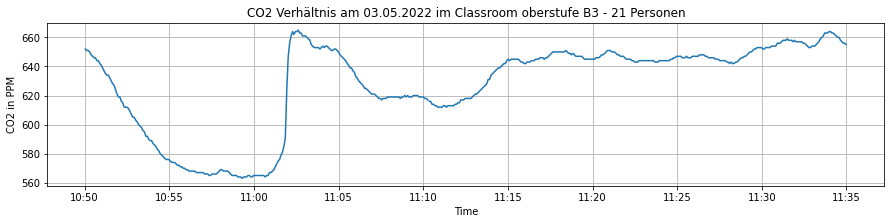

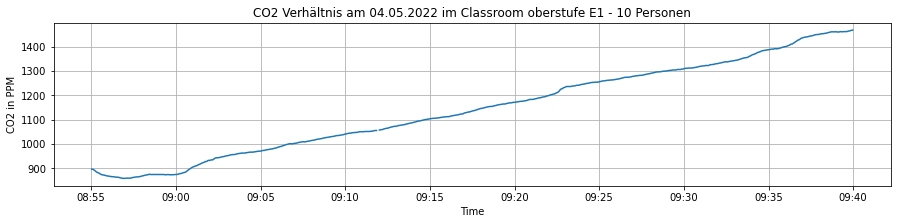

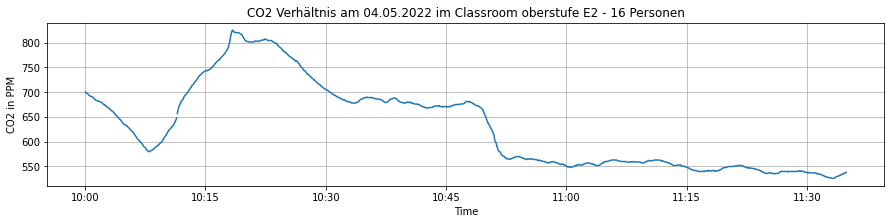

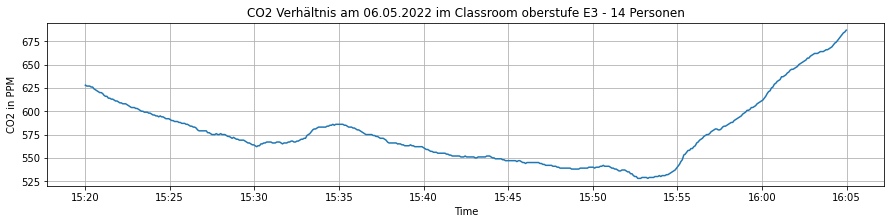

In [16]:
# Auswertung Oberstufe

# Missing Data at the moment : B1 = get_measurement(name = "oberstufe", startDate = "2022-05-02 10:00:00", endDate = "2022-05-02 11:35:00")

B2 = get_measurement(name = "oberstufe", startDate = "2022-05-05 10:00:00", endDate = "2022-05-05 11:35:00")


plt.figure(figsize = (15,3))
plt.plot(B2["time"], B2["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 05.05.2022 im Classroom oberstufe B2 - 13 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

B3 = get_measurement(name = "oberstufe", startDate = "2022-05-03 10:50:00", endDate = "2022-05-03 11:35:00")

plt.figure(figsize = (15,3))
plt.plot(B3["time"], B3["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom oberstufe B3 - 21 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

E1 = get_measurement(name = "oberstufe", startDate = "2022-05-04 8:55:00", endDate = "2022-05-04 9:40:00")

plt.figure(figsize = (15,3))
plt.plot(E1["time"], E1["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 04.05.2022 im Classroom oberstufe E1 - 10 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

E2 = get_measurement(name = "oberstufe", startDate = "2022-05-04 10:00:00", endDate = "2022-05-04 11:35:00")

plt.figure(figsize = (15,3))
plt.plot(E2["time"], E2["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 04.05.2022 im Classroom oberstufe E2 - 16 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

E3 = get_measurement(name = "oberstufe", startDate = "2022-05-06 15:20:00", endDate = "2022-05-06 16:05:00")

plt.figure(figsize = (15,3))
plt.plot(E3["time"], E3["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 06.05.2022 im Classroom oberstufe E3 - 14 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


### Lässt sich aus den Messdaten der optimale Zeitpunkt zum Lüften (laufend) ermitteln?

In [17]:
# psdeudo:
# Select time, max(co2) from Primarklasse_OG1 where time > '2020-05-03 08:00:00' and time < '2020-05-03 17:30:00'
# Select time, min(Co2) from Primarklasse_OG1 where in between (time_from 30 min before previous querry) and (time_to previous query)
Monday_05_02 = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-02 08:00:00", endDate = "2022-05-02 18:30:00")
Tuesday_05_03 = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 18:30:00")
Wendsday_05_04 = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-04 08:00:00", endDate = "2022-05-04 18:30:00")
Thursday_05_05 = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-05 08:00:00", endDate = "2022-05-05 18:30:00")
Firday_05_06 = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-06 08:00:00", endDate = "2022-05-06 18:30:00")

column = Monday_05_02["co2"]

print(Monday_05_02['co2'].max())

max_entry_m = Monday_05_02.query(f"co2 == {Monday_05_02['co2'].max()}")
max_entry_t = Tuesday_05_03.query(f"co2 == {Tuesday_05_03['co2'].max()}")
max_entry_w =Wendsday_05_04.query(f"co2 == {Wendsday_05_04['co2'].max()}")
max_entry_t =Thursday_05_05.query(f"co2 == {Thursday_05_05['co2'].max()}")
max_entry_f =Firday_05_06.query(f"co2 == {Firday_05_06['co2'].max()}")

print((max_entry_m['time'].values[0]))

Monday_05_02.query(f"time == '{pd.to_datetime(max_entry_m['time'].values[0])}'")

1011.0
2022-05-02T12:59:45.540150000


,id,name,description,room_number,updated_on,id,active,name,fk_classroom_id,id,time,co2,temperature,humidity,insert_time,fk_measurement_station_id,light,motion


### Welche weiteren Erkenntnisse lassen sich aus den erfassten Messdaten ableiten?

#### Soll man auch wegen der Luftfeuchtigkeit lüften?

In [18]:
data = get_measurement(name = "Primarklasse_OG1", startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 09:30:00")
meteo = get_meteo(startDate = "2022-05-03 08:00:00", endDate = "2022-05-03 09:30:00")

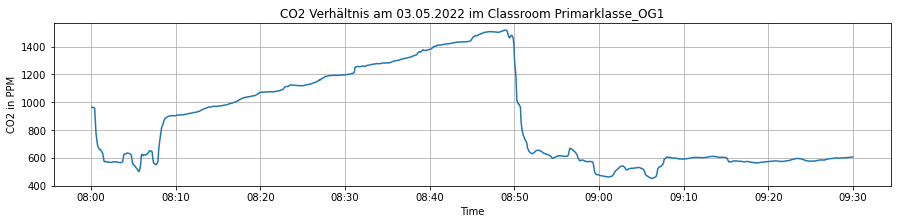

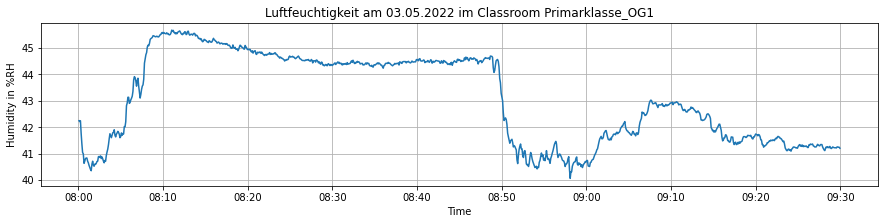

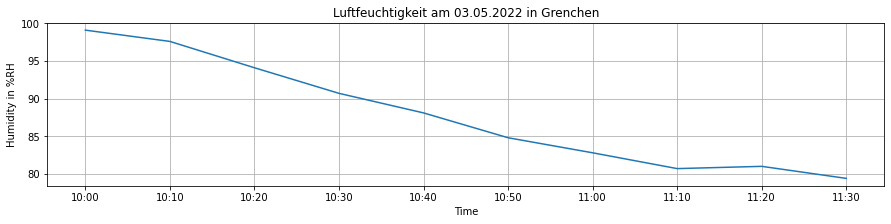

In [19]:
plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom Primarklasse_OG1")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["humidity"])
plt.xlabel("Time")
plt.ylabel("Humidity in %RH")
plt.title("Luftfeuchtigkeit am 03.05.2022 im Classroom Primarklasse_OG1")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(meteo.index, meteo.iloc[:, 4])
plt.xlabel("Time")
plt.ylabel("Humidity in %RH")
plt.title("Luftfeuchtigkeit am 03.05.2022 in Grenchen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

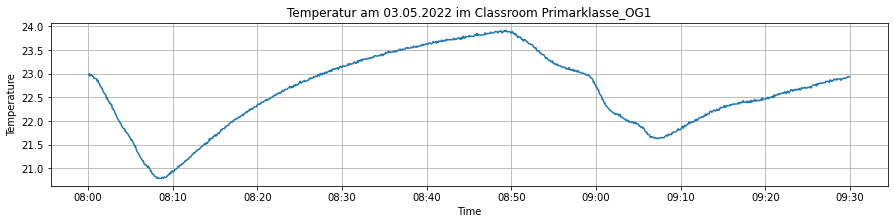

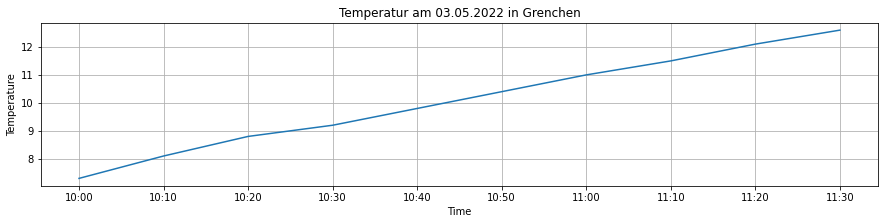

In [20]:
plt.figure(figsize = (15,3))
plt.plot(data["time"], data["temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperatur am 03.05.2022 im Classroom Primarklasse_OG1")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(meteo.index, meteo.iloc[:, 1])
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperatur am 03.05.2022 in Grenchen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

In [21]:
data = get_measurement(name = "oberstufe", startDate = "2022-04-26 08:00:00", endDate = "2022-04-26 09:30:00")
meteo = get_meteo(startDate = "2022-04-26 08:00:00", endDate = "2022-04-26 09:30:00")

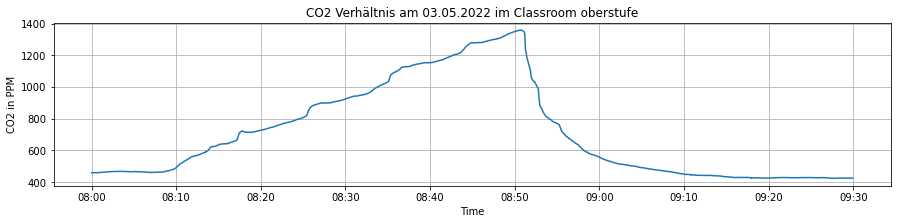

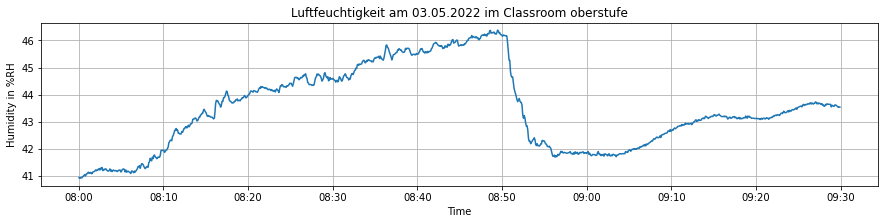

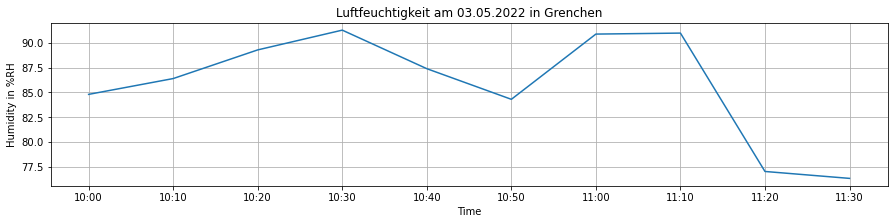

In [22]:
plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["humidity"])
plt.xlabel("Time")
plt.ylabel("Humidity in %RH")
plt.title("Luftfeuchtigkeit am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(meteo.index, meteo.iloc[:, 4])
plt.xlabel("Time")
plt.ylabel("Humidity in %RH")
plt.title("Luftfeuchtigkeit am 03.05.2022 in Grenchen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

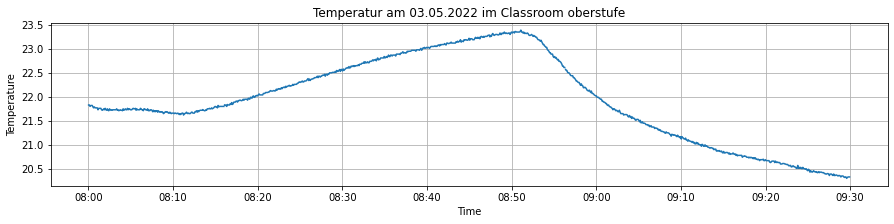

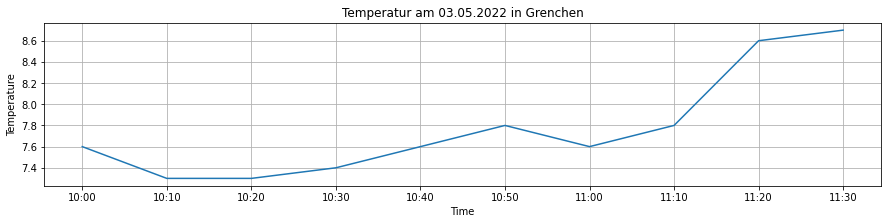

In [23]:
plt.figure(figsize = (15,3))
plt.plot(data["time"], data["temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperatur am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

plt.figure(figsize = (15,3))
plt.plot(meteo.index, meteo.iloc[:, 1])
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperatur am 03.05.2022 in Grenchen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

#### Ist die Luftqualität und Temperatur der Klassenzimmer überhaupt gut?

In [24]:
data_eg = get_measurement(name = "Primarklasse_EG", startDate = "2022-04-21 00:00:00", endDate = "2022-05-12 00:00:00")

data_og = get_measurement(name = "Primarklasse_OG1", startDate = "2022-04-21 00:00:00", endDate = "2022-05-12 00:00:00")

data_os = get_measurement(name = "oberstufe", startDate = "2022-04-21 00:00:00", endDate = "2022-05-12 00:00:00")

data = pd.concat([data_eg, data_og, data_os]).reset_index()

meteo = get_meteo(startDate = "2022-04-21 00:00:00", endDate = "2022-05-12 00:00:00")


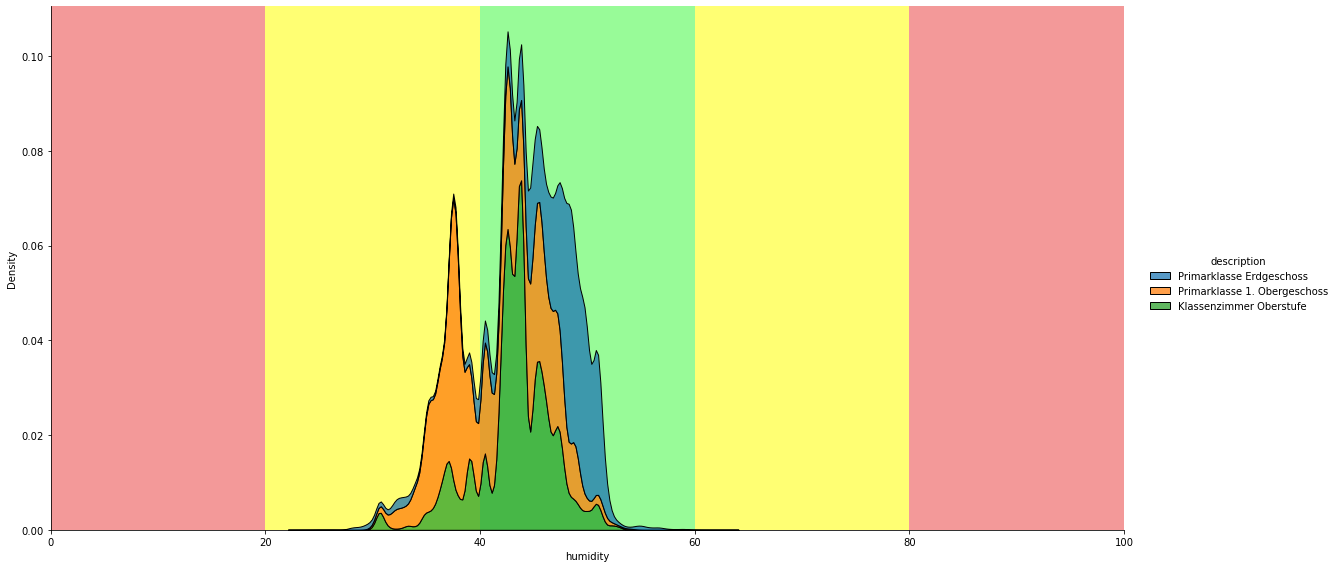

In [25]:
sns.displot(data, x = "humidity", kind = "kde", hue = "description", height = 8, aspect = 2, multiple = "stack", zorder = 2)
plt.xlim(0, 100)

plt.axvspan(0, 20, facecolor = "lightcoral", alpha = 0.8, zorder = 1)
plt.axvspan(20, 40, facecolor = "yellow", alpha = 0.55, zorder = 1)
plt.axvspan(40, 60, facecolor = "palegreen", zorder = 1)
plt.axvspan(60, 80, facecolor = "yellow", alpha = 0.55, zorder = 1)
plt.axvspan(80, 100, facecolor = "lightcoral", alpha = 0.8, zorder = 1)

plt.show()

#### Kann man durch gescheites und wetterabhängiges Lüften Energie sparen?

### Welche Erkenntnisse von Dritten können Sie allenfalls bestätigen/widerlegen?

--- Markdown ---